# Part A


In [4]:
import numpy as np
import scipy.spatial
from starter import *
import torch

In [5]:
#####################################################################
## Models used for predictions.
#####################################################################
def compute_update(single_obj_loc, sensor_loc, single_distance):
    """
    Compute the gradient of the loglikelihood function for part a.

    Input:
    single_obj_loc: 1 * d numpy array.
    Location of the single object.

    sensor_loc: k * d numpy array.
    Location of sensor.

    single_distance: k dimensional numpy array.
    Observed distance of the object.

    Output:
    grad: d-dimensional numpy array.

    """
    loc_difference = single_obj_loc - sensor_loc  # k * d.
    phi = np.linalg.norm(loc_difference, axis=1)  # k.
    grad = loc_difference / np.expand_dims(phi, 1)  # k * 2.
    update = np.linalg.solve(
        grad.T.dot(grad), grad.T.dot(single_distance - phi))

    return update


def get_object_location(sensor_loc,
                        single_distance,
                        num_iters=20,
                        num_repeats=10):
    """
    Compute the gradient of the loglikelihood function for part a.

    Input:

    sensor_loc: k * d numpy array. Location of sensor.

    single_distance: k dimensional numpy array.
    Observed distance of the object.

    Output:
    obj_loc: 1 * d numpy array. The mle for the location of the object.

    """
    obj_locs = np.zeros((num_repeats, 1, 2))
    distances = np.zeros(num_repeats)
    for i in range(num_repeats):
        obj_loc = np.random.randn(1, 2) * 100
        for t in range(num_iters):
            obj_loc += compute_update(obj_loc, sensor_loc, single_distance)

        distances[i] = np.sum(
            (single_distance - np.linalg.norm(obj_loc - sensor_loc, axis=1))
            **2)
        obj_locs[i] = obj_loc

    obj_loc = obj_locs[np.argmin(distances)]

    return obj_loc[0]


def generative_model(X, Y, Xs_test, Ys_test):
    """
    This function implements the generative model.
    Input:
    X: independent variables in training data.
    Y: dependent variables in training data.
    Xs_test: independent variables in test data.
    Ys_test: dependent variables in test data.
    Output:
    mse: Mean square error on test data.
    """
    initial_sensor_loc = np.random.randn(7, 2) * 100
    estimated_sensor_loc = find_mle_by_grad_descent_part_e(
        initial_sensor_loc, Y, X, lr=0.001, num_iters=1000)

    mses = []
    for i, X_test in enumerate(Xs_test):
        Y_test = Ys_test[i]
        Y_pred = np.array([
            get_object_location(estimated_sensor_loc, X_test_single)
            for X_test_single in X_test
        ])
        mse = np.mean(np.sqrt(np.sum((Y_pred - Y_test)**2, axis=1)))
        mses.append(mse)
    return mses


def oracle_model(X, Y, Xs_test, Ys_test, sensor_loc):
    """
    This function implements the generative model.
    Input:
    X: independent variables in training data.
    Y: dependent variables in training data.
    Xs_test: independent variables in test data.
    Ys_test: dependent variables in test data.
    sensor_loc: location of the sensors.
    Output:
    mse: Mean square error on test data.
    """
    mses = []
    for i, X_test in enumerate(Xs_test):
        Y_test = Ys_test[i]
        Y_pred = np.array([
            get_object_location(sensor_loc, X_test_single)
            for X_test_single in X_test
        ])
        mse = np.mean(np.sqrt(np.sum((Y_pred - Y_test)**2, axis=1)))
        mses.append(mse)
    return mses


def zero_model(X, Y, Xs_test, Ys_test, sensor_loc):
    """
    This function implements the zero model: always predict zero
    Input:
    X: independent variables in training data.
    Y: dependent variables in training data.
    Xs_test: independent variables in test data.
    Ys_test: dependent variables in test data.
    sensor_loc: location of the sensors.
    Output:
    mse: Mean square error on test data.
    """
    mses = []
    for i, X_test in enumerate(Xs_test):
        Y_test = Ys_test[i]
        Y_pred = np.zeros(Y_test.shape)
        mse = np.mean(np.sqrt(np.sum((Y_pred - Y_test)**2, axis=1)))
        mses.append(mse)
    return mses


def construct_second_order_data(X):
    """
    This function computes second order variables
    for polynomial regression.
    Input:
    X: Independent variables.
    Output:
    A data matrix composed of both first and second order terms.
    """
    X_second_order = []
    m = X.shape[1]
    for i in range(m):
        for j in range(m):
            if j <= i:
                X_second_order.append(X[:, i] * X[:, j])
    X_second_order = np.array(X_second_order).T
    return np.concatenate((X, X_second_order), axis=1)


def linear_regression(X, Y, Xs_test, Ys_test):
    """
    This function performs linear regression.
    Input:
    X: independent variables in training data.
    Y: dependent variables in training data.
    Xs_test: independent variables in test data.
    Ys_test: dependent variables in test data.
    Output:
    mse: Mean square error on test data.
    """

    ## YOUR CODE HERE
    ### start linReg ###
    w = np.linalg.lstsq(X, Y)[0]
    mses = []
    for X_test, Y_test in zip(Xs_test, Ys_test):
        mses.append(np.mean(np.linalg.norm(Y_test - X_test @ w)**2))
    ### end linReg ###
    return mses


def poly_regression_second(X, Y, Xs_test, Ys_test):
    """
    This function performs second order polynomial regression.
    Input:
    X: independent variables in training data.
    Y: dependent variables in training data.
    Xs_test: independent variables in test data.
    Ys_test: dependent variables in test data.
    Output:
    mse: Mean square error on test data.
    """
    ## YOUR CODE HERE
    ### start polyReg ###
    
    w = np.linalg.lstsq(construct_second_order_data(X), Y)[0]
    mses = []
    for X_test, Y_test in zip(Xs_test, Ys_test):
        mses.append(np.mean(np.linalg.norm(Y_test - construct_second_order_data(X_test) @ w)**2))
    ### end polyReg ###
    return mses


def poly_regression_cubic(X, Y, Xs_test, Ys_test):
    """
    This function performs third order polynomial regression.
    Input:
    X: independent variables in training data.
    Y: dependent variables in training data.
    Xs_test: independent variables in test data.
    Ys_test: dependent variables in test data.
    Output:
    mse: Mean square error on test data.
    """
    ## YOUR CODE HERE
    ### start cubReg ###
    mses = []
    
    ### end cubReg ###
    return mses


def neural_network(X, Y, Xs_test, Ys_test):
    """
    This function performs neural network prediction.
    Input:
    X: independent variables in training data.
    Y: dependent variables in training data.
    Xs_test: independent variables in test data.
    Ys_test: dependent variables in test data.
    Output:
    mse: Mean square error on test data.
    """
    ## YOUR CODE HERE
    ### start nn ###
    mses = []
    D_in = X.shape[1]
    D_out = Y.shape[1]
    H = 100
    model = torch.nn.Sequential(
        torch.nn.Linear(D_in, H),
        torch.nn.ReLU(),
        torch.nn.Linear(H, H),
        torch.nn.ReLU(),
        torch.nn.Linear(H, D_out),
    )
    loss_fn = torch.nn.MSELoss(reduction='sum')
    optimizer = torch.optim.SGD(model.parameters(), lr=0.01)
    x = torch.from_numpy(X).float()
    y = torch.from_numpy(Y).float()
    for i in range(3):
        optimizer.zero_grad()
        output = model(x)
        
        loss = loss_fn(output, y)
        loss.backward()
        optimizer.step()
    mses = []

    ### end nn ###
    return mses


# Part B


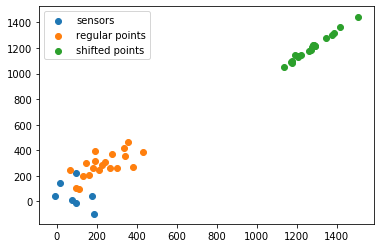

In [6]:
# plot 0
import matplotlib.pyplot as plt


np.random.seed(0)
sensor_loc = generate_sensors()
regular_loc, _ = generate_dataset(
    sensor_loc,
    num_sensors=sensor_loc.shape[0],
    spatial_dim=2,
    num_data=20,
    original_dist=True,
    noise=1)
shifted_loc, _ = generate_dataset(
    sensor_loc,
    num_sensors=sensor_loc.shape[0],
    spatial_dim=2,
    num_data=20,
    original_dist=False,
    noise=1)

plt.scatter(sensor_loc[:, 0], sensor_loc[:, 1], label="sensors")
plt.scatter(regular_loc[:, 0], regular_loc[:, 1], label="regular points")
plt.scatter(shifted_loc[:, 0], shifted_loc[:, 1], label="shifted points")
plt.legend()
plt.savefig("dataset.png")
plt.show()


# Part C


In [ ]:
#plot 1
np.random.seed(0)
ns = np.arange(10, 310, 20)
replicates = 5
num_methods = 7
num_sets = 3
mses = np.zeros((len(ns), replicates, num_methods, num_sets))
def generate_data(sensor_loc, k=7, d=2, n=1, original_dist=True, noise=1):
    return generate_dataset(
        sensor_loc,
        num_sensors=k,
        spatial_dim=d,
        num_data=n,
        original_dist=original_dist,
        noise=noise)
for s in range(replicates):
    sensor_loc = generate_sensors()
    X_test, Y_test = generate_data(sensor_loc, n=1000)
    X_test2, Y_test2 = generate_data(
        sensor_loc, n=1000, original_dist=False)
    for t, n in enumerate(ns):
        X, Y = generate_data(sensor_loc, n=n)  # X [n * 2] Y [n * 7]
        Xs_test, Ys_test = [X, X_test, X_test2], [Y, Y_test, Y_test2]
        ### Linear regression:
        mse = linear_regression(X, Y, Xs_test, Ys_test)
        mses[t, s, 0] = mse
        ### Second-order Polynomial regression:
        mse = poly_regression_second(X, Y, Xs_test, Ys_test)
        mses[t, s, 1] = mse
#         ### 3rd-order Polynomial regression:
#         mse = poly_regression_cubic(X, Y, Xs_test, Ys_test)
#         mses[t, s, 2] = mse
        ### Neural Network:
        mse = neural_network(X, Y, Xs_test, Ys_test)
        mses[t, s, 3] = mse
        print (mse)
#         ### Generative model:
#         mse = generative_model(X, Y, Xs_test, Ys_test)
#         mses[t, s, 4] = mse
#         ### Oracle model:
#         mse = oracle_model(X, Y, Xs_test, Ys_test, sensor_loc)
#         mses[t, s, 5] = mse
#         ### Zero model:
#         mse = zero_model(X, Y, Xs_test, Ys_test, sensor_loc)
#         mses[t, s, 6] = mse
        print('{}th Experiment with {} samples done...'.format(s, n))
### Plot MSE for each model.
plt.figure()
regressors = [
    'Linear Regression', '2nd-order Polynomial Regression',
    '3rd-order Polynomial Regression', 'Neural Network',
    'Generative Model', 'Oracle Model', 'Zero Model'
]
for a in range(7):
    plt.plot(ns, np.mean(mses[:, :, a, 0], axis=1), label=regressors[a])
plt.title('Error on training data for Various models')
plt.xlabel('Number of training data')
plt.ylabel('Average Error')
plt.legend(loc='best')
plt.yscale('log')
plt.savefig('train_mse.png')
plt.show()
plt.figure()
for a in range(7):
    plt.plot(ns, np.mean(mses[:, :, a, 1], axis=1), label=regressors[a])
plt.title(
    'Error on test data from the same distribution for Various models')
plt.xlabel('Number of training data')
plt.ylabel('Average Error')
plt.legend(loc='best')
plt.yscale('log')
plt.savefig('val_same_mse.png')
plt.show()
plt.figure()
for a in range(7):
    plt.plot(ns, np.mean(mses[:, :, a, 2], axis=1), label=regressors[a])
plt.title(
    'Error on test data from a different distribution for Various models')
plt.xlabel('Number of training data')
plt.ylabel('Average Error')
plt.legend(loc='best')
plt.yscale('log')
plt.savefig('val_different_mse.png')
plt.show()


# Part D


Experiment with 100 neurons done...
Experiment with 150 neurons done...
Experiment with 200 neurons done...
Experiment with 250 neurons done...
Experiment with 300 neurons done...
Experiment with 350 neurons done...
Experiment with 400 neurons done...
Experiment with 450 neurons done...
Experiment with 500 neurons done...


//anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:63: UserWarning: Data has no positive values, and therefore cannot be log-scaled.


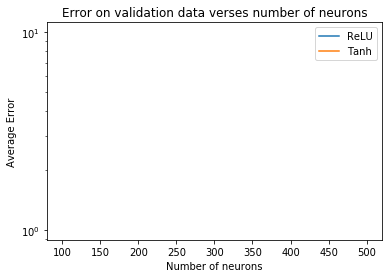

In [6]:
# plot 2
def neural_network(X, Y, X_test, Y_test, num_neurons, activation):
    """
    This function performs neural network prediction.
    Input:
    X: independent variables in training data.
    Y: dependent variables in training data.
    X_test: independent variables in test data.
    Y_test: dependent variables in test data.
    Output:
    mse: Mean square error on test data.
    """
    mse = 0
    ### start nn2 ###

    ### end nn2 ###
    return mse

#############################################################################
#######################PLOT PART 2###########################################
#############################################################################
def generate_data(sensor_loc, k=7, d=2, n=1, original_dist=True, noise=1):
    return generate_dataset(
        sensor_loc,
        num_sensors=k,
        spatial_dim=d,
        num_data=n,
        original_dist=original_dist,
        noise=noise)


np.random.seed(0)
n = 200
num_neuronss = np.arange(100, 550, 50)
mses = np.zeros((len(num_neuronss), 2))

# for s in range(replicates):

sensor_loc = generate_sensors()
X, Y = generate_data(sensor_loc, n=n)  # X [n * 2] Y [n * 7]
X_test, Y_test = generate_data(sensor_loc, n=1000)
for t, num_neurons in enumerate(num_neuronss):
    ### Neural Network:
    mse = neural_network(X, Y, X_test, Y_test, num_neurons, ReLUActivation)
    mses[t, 0] = mse

    mse = neural_network(X, Y, X_test, Y_test, num_neurons, TanhActivation)
    mses[t, 1] = mse

    # print('{}th Experiment with {} samples done...'.format(s, n))
    print('Experiment with {} neurons done...'.format(num_neurons))

### Plot MSE for each model.
plt.figure()
activation_names = ['ReLU', 'Tanh']
for a in range(2):
    plt.plot(num_neuronss, mses[:, a], label=activation_names[a])

plt.title('Error on validation data verses number of neurons')
plt.xlabel('Number of neurons')
plt.ylabel('Average Error')
plt.legend(loc='best')
plt.yscale('log')
plt.savefig('num_neurons.png')


# Part E


In [ ]:
# plot 3

def neural_network(X, Y, X_test, Y_test, num_layers, activation):
    """
    This function performs neural network prediction.
    Input:
    X: independent variables in training data.
    Y: dependent variables in training data.
    X_test: independent variables in test data.
    Y_test: dependent variables in test data.
    Output:
    mse: Mean square error on test data.
    """
    ### start nn3 ###

    ### end nn3 ###
    return mse


#############################################################################
#######################PLOT PART 2###########################################
#############################################################################
def generate_data(sensor_loc, k=7, d=2, n=1, original_dist=True, noise=1):
    return generate_dataset(
        sensor_loc,
        num_sensors=k,
        spatial_dim=d,
        num_data=n,
        original_dist=original_dist,
        noise=noise)


np.random.seed(0)
n = 200
num_layerss = [1, 2, 3, 4]
mses = np.zeros((len(num_layerss), 2))

# for s in range(replicates):
sensor_loc = generate_sensors()
X, Y = generate_data(sensor_loc, n=n)  # X [n * 2] Y [n * 7]
X_test, Y_test = generate_data(sensor_loc, n=1000)
for t, num_layers in enumerate(num_layerss):
    ### Neural Network:
    mse = neural_network(X, Y, X_test, Y_test, num_layers, ReLUActivation)
    mses[t, 0] = mse

    mse = neural_network(X, Y, X_test, Y_test, num_layers, TanhActivation)
    mses[t, 1] = mse

    # print('{}th Experiment with {} samples done...'.format(s, n))
    print('Experiment with {} layers done...'.format(num_layers))

### Plot MSE for each model.
plt.figure()
activation_names = ['ReLU', 'Tanh']
for a in range(2):
    plt.plot(num_layerss, mses[:, a], label=activation_names[a])

plt.title('Error on validation data verses number of neurons')
plt.xlabel('Number of layers')
plt.ylabel('Average Error')
plt.legend(loc='best')
plt.yscale('log')
plt.savefig('num_layers.png')


# Part F


In [ ]:
# plot4

def neural_network(X, Y, Xs_test, Ys_test):
    """
    This function performs neural network prediction.
    Input:
    X: independent variables in training data.
    Y: dependent variables in training data.
    X_test: independent variables in test data.
    Y_test: dependent variables in test data.
    Output:
    mse: Mean square error on test data.
    """
    mses = 0
    ### start nn4 ###

    ### end nn4 ###
    return mses



#############################################################################
#######################PLOT PART 1###########################################
#############################################################################
np.random.seed(0)

ns = np.arange(10, 310, 20)
replicates = 5
num_methods = 6
num_sets = 3
mses = np.zeros((len(ns), replicates, num_methods, num_sets))

def generate_data(sensor_loc, k=7, d=2, n=1, original_dist=True, noise=1):
    return generate_dataset(
        sensor_loc,
        num_sensors=k,
        spatial_dim=d,
        num_data=n,
        original_dist=original_dist,
        noise=noise)

for s in range(replicates):
    sensor_loc = generate_sensors()
    X_test, Y_test = generate_data(sensor_loc, n=1000)
    X_test2, Y_test2 = generate_data(
        sensor_loc, n=1000, original_dist=False)
    for t, n in enumerate(ns):
        X, Y = generate_data(sensor_loc, n=n)  # X [n * 2] Y [n * 7]
        Xs_test, Ys_test = [X, X_test, X_test2], [Y, Y_test, Y_test2]
        ### Linear regression:
        mse = linear_regression(X, Y, Xs_test, Ys_test)
        mses[t, s, 0] = mse

        ### Second-order Polynomial regression:
        mse = poly_regression_second(X, Y, Xs_test, Ys_test)
        mses[t, s, 1] = mse

        ### 3rd-order Polynomial regression:
        mse = poly_regression_cubic(X, Y, Xs_test, Ys_test)
        mses[t, s, 2] = mse

        ### Neural Network:
        mse = neural_network(X, Y, Xs_test, Ys_test)
        mses[t, s, 3] = mse

        ### Generative model:
        mse = generative_model(X, Y, Xs_test, Ys_test)
        mses[t, s, 4] = mse

        ### Oracle model:
        mse = oracle_model(X, Y, Xs_test, Ys_test, sensor_loc)
        mses[t, s, 5] = mse

        print('{}th Experiment with {} samples done...'.format(s, n))

### Plot MSE for each model.
plt.figure()
regressors = [
    'Linear Regression', '2nd-order Polynomial Regression',
    '3rd-order Polynomial Regression', 'Neural Network',
    'Generative Model', 'Oracle Model'
]
for a in range(6):
    plt.plot(ns, np.mean(mses[:, :, a, 0], axis=1), label=regressors[a])

plt.title('Error on training data for Various models')
plt.xlabel('Number of training data')
plt.ylabel('Average Error')
plt.legend(loc='best')
plt.yscale('log')
plt.savefig('best_train_mse.png')
plt.show()

plt.figure()
for a in range(6):
    plt.plot(ns, np.mean(mses[:, :, a, 1], axis=1), label=regressors[a])

plt.title(
    'Error on test data from the same distribution for Various models')
plt.xlabel('Number of training data')
plt.ylabel('Average Error')
plt.legend(loc='best')
plt.yscale('log')
plt.savefig('best_val_same_mse.png')
plt.show()

plt.figure()
for a in range(6):
    plt.plot(ns, np.mean(mses[:, :, a, 2], axis=1), label=regressors[a])

plt.title(
    'Error on test data from a different distribution for Various models')
plt.xlabel('Number of training data')
plt.ylabel('Average Error')
plt.legend(loc='best')
plt.yscale('log')
plt.savefig('best_val_different_mse.png')
plt.show()
